In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
from prettytable import PrettyTable
from datetime import date
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings( "ignore")
sns.set_theme(style='whitegrid', palette='pastel')

plt.rcParams["figure.figsize"] = (12, 8)

# Step 1: Data preprocessing into time series

In [2]:
path = 'https://drive.google.com/file/d/1i_VkX57he5_QICWnX-egL2AHpW0yEDvd/view?usp=share_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]

df = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
df.drop(df.columns[0], axis=1, inplace=True)

print(list(df.columns))
df.head()

['id', 'long', 'lat', 'light', 'weather', 'nearby', 'road_conditions', 'category', 'severity', 'datetime', 'region', 'parent_region', 'participants_count', 'injured_count', 'dead_count', 'month', 'weekday', 'time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']


,id,long,lat,light,weather,nearby,road_conditions,category,severity,datetime,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1561495,37.608056,55.689444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Крупный торгов...","['Заснеженное', 'Отсутствие, плохая различимос...",Наезд на препятствие,С погибшими,2015-01-01 00:23:00,...,-10,12,100,96,0.0,1011,-6,2,263,9
1,2365887,91.543006,55.361608,"В темное время суток, освещение не включено",['Ясно'],[],['Сухое'],Наезд на препятствие,Тяжёлый,2015-01-01 00:50:00,...,-16,15,68,96,0.0,1025,-12,2,212,7
2,1561392,37.752778,55.661667,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Нерегулируемый...",['Обработанное противогололедными материалами'],Наезд на пешехода,Тяжёлый,2015-01-01 01:00:00,...,-10,16,100,96,0.0,1010,-6,3,268,11
3,1913663,1.000000,1.000000,"В темное время суток, освещение включено",['Пасмурно'],[],['Мокрое'],Наезд на стоящее ТС,Легкий,2015-01-01 01:15:00,...,-3,22,91,97,0.0,1008,1,5,271,13
4,1561530,37.405833,55.649444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Выезд с прилег...","['Недостатки зимнего содержания', 'Заснеженное']",Столкновение,Тяжёлый,2015-01-01 01:39:00,...,-10,16,100,96,0.0,1010,-6,3,268,11


4 chosen variables are:
- tempC (predictor);
- visibility (predictor);
- injured_count (target variable);
- severity (target variable).

Preprocessing of variables:
- tempC - average over the day;
- visibility - average over the day;
- injured_count - average over the day;
- severity - mapping severity levels to integers starting from 1 (there may be days with no accidents), then average over day.

In [3]:
ts = df[['datetime', 'tempC', 'visibility', 'injured_count', 'severity']].copy()
print(f"Unique severity levels: {list(df['severity'].unique())}")

sev_map = {'С погибшими': 3, 'Тяжёлый': 2, 'Легкий': 1}
map_severity = lambda x: sev_map[x]

ts['datetime'] = pd.to_datetime(ts['datetime']).dt.date
ts['severity'] = ts['severity'].apply(map_severity)

print(f"Dates from {df['datetime'].min()} to {df['datetime'].max()}")
ts = ts.groupby(['datetime']).mean()
ts.head()

Unique severity levels: ['С погибшими', 'Тяжёлый', 'Легкий']
Dates from 2015-01-01 00:23:00 to 2022-10-31 21:03:00


,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,-2.574468,5.829787,1.255319,1.553191
2015-01-02,-2.040000,5.460000,1.640000,1.540000
2015-01-03,-5.790698,3.906977,1.209302,1.697674
2015-01-04,-5.666667,5.300000,1.033333,1.433333
2015-01-05,-10.687500,5.531250,1.187500,1.468750


Number of days: 2861


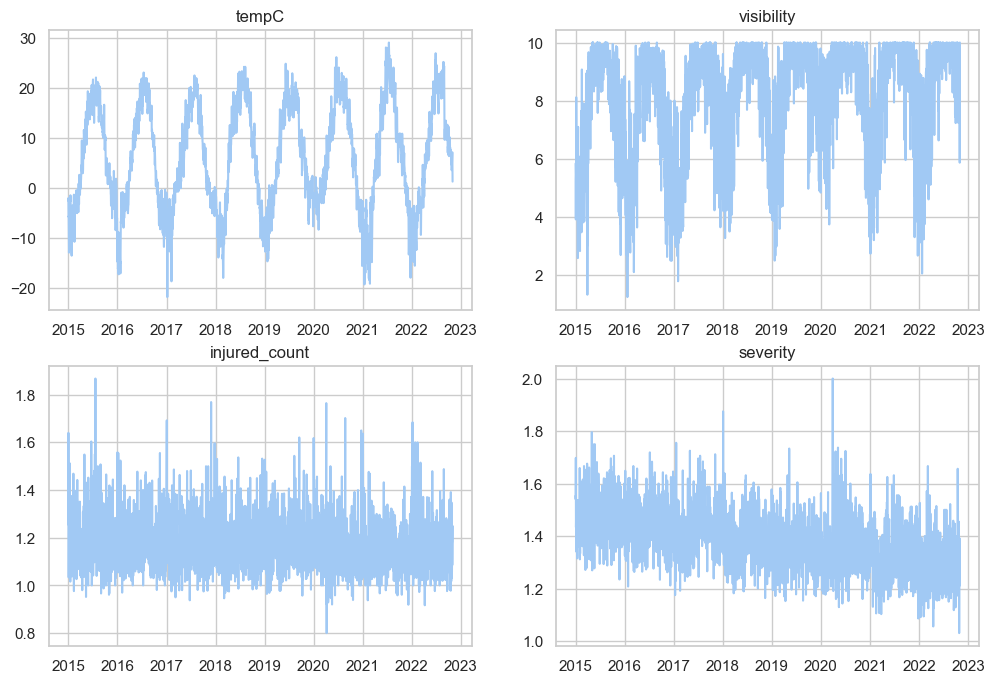

In [4]:
print(f"Number of days: {len(ts)}")

for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(ts[item])

# Step 2: Stationarity analysis

In [11]:
for num, item in enumerate(ts.columns):
    result = smt.stattools.adfuller(ts[item])
    print(f"\nVariable: {item}")
    print("Augmented Dickey-Fuller test:")
    print(f"\tStatistic value = {result[0]:.5f}\n\tp-value = {result[1]:.5f}")
    print("\tStationary" if result[1] < 0.05 else "\tNon-stationary")


Variable: tempC
Augmented Dickey-Fuller test:
	Statistic value = -3.40413
	p-value = 0.01082
	Stationary

Variable: visibility
Augmented Dickey-Fuller test:
	Statistic value = -4.49780
	p-value = 0.00020
	Stationary

Variable: injured_count
Augmented Dickey-Fuller test:
	Statistic value = -7.77946
	p-value = 0.00000
	Stationary

Variable: severity
Augmented Dickey-Fuller test:
	Statistic value = -3.05193
	p-value = 0.03032
	Stationary


All four time series seemed to be stationary for mathematical expectation and variance (with the augmented Dickey-Fuller test). No further processing is needed.

# Step 3: Analysis of covariance among targets and predictors 

## Autocovariance

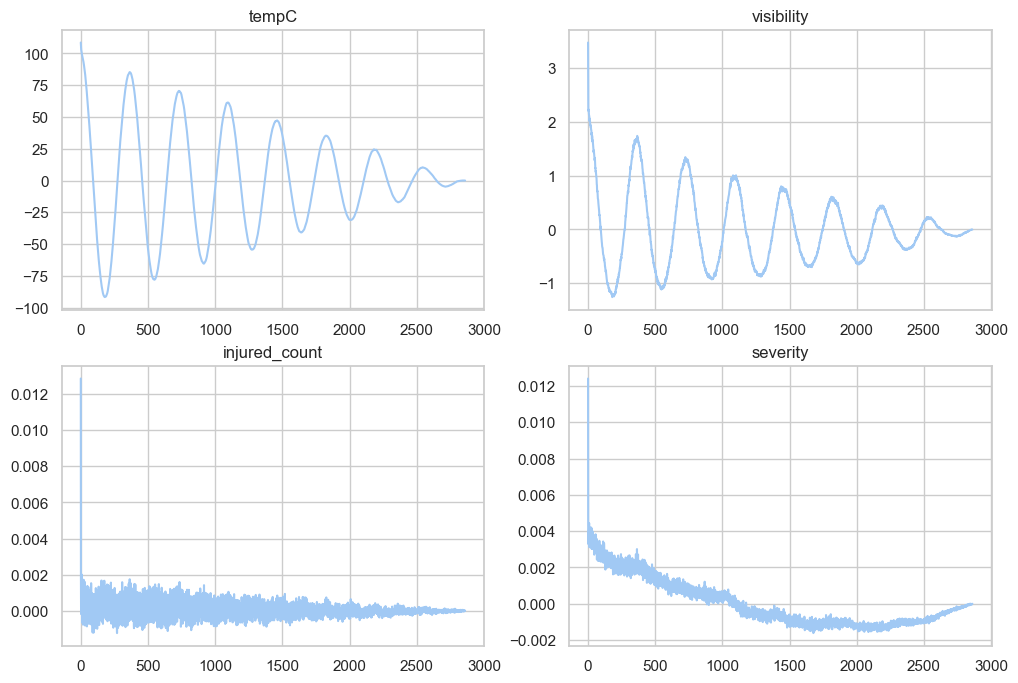

In [13]:
for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(stattools.acovf(ts[item], fft=False)) # autocovariance without window

Autocovariance:
1. tempC and visibility show significant yearly autocovariance;
2. injured_count and severity may have very slight autocovariance with smaller periods.

As point 1 is obvious, point 2 is not, so are better visualized with ACF plots:

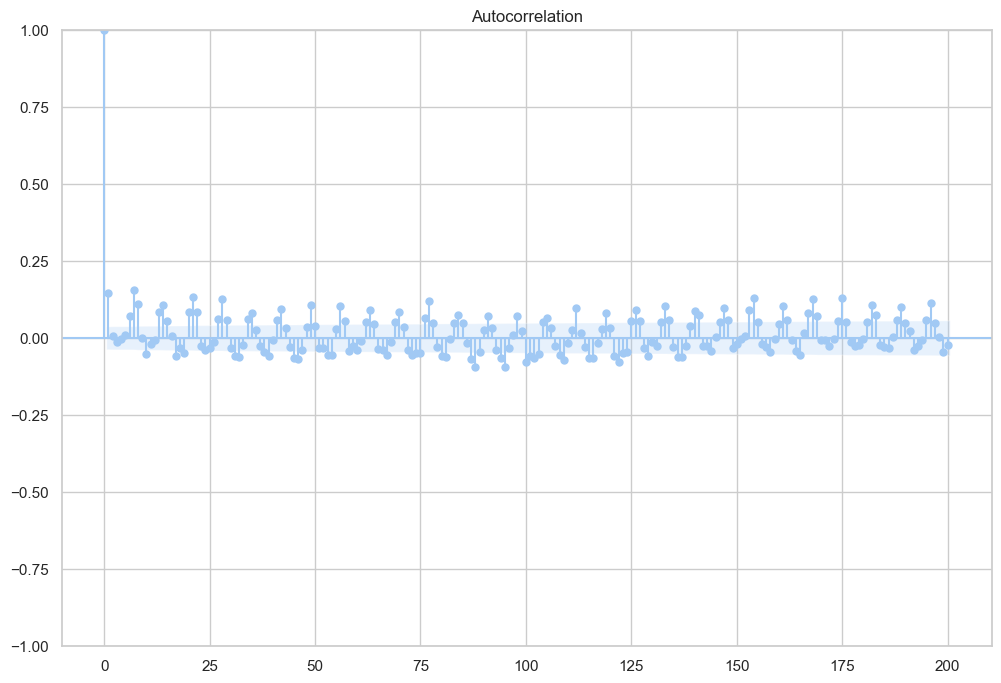

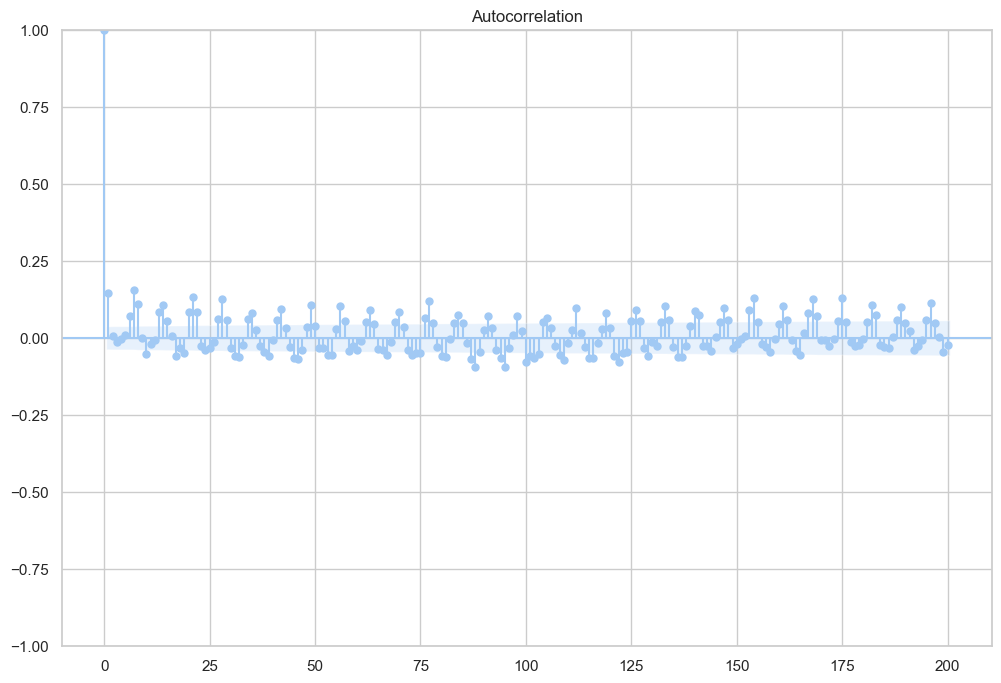

In [17]:
plot_acf(ts['injured_count'], lags=200)

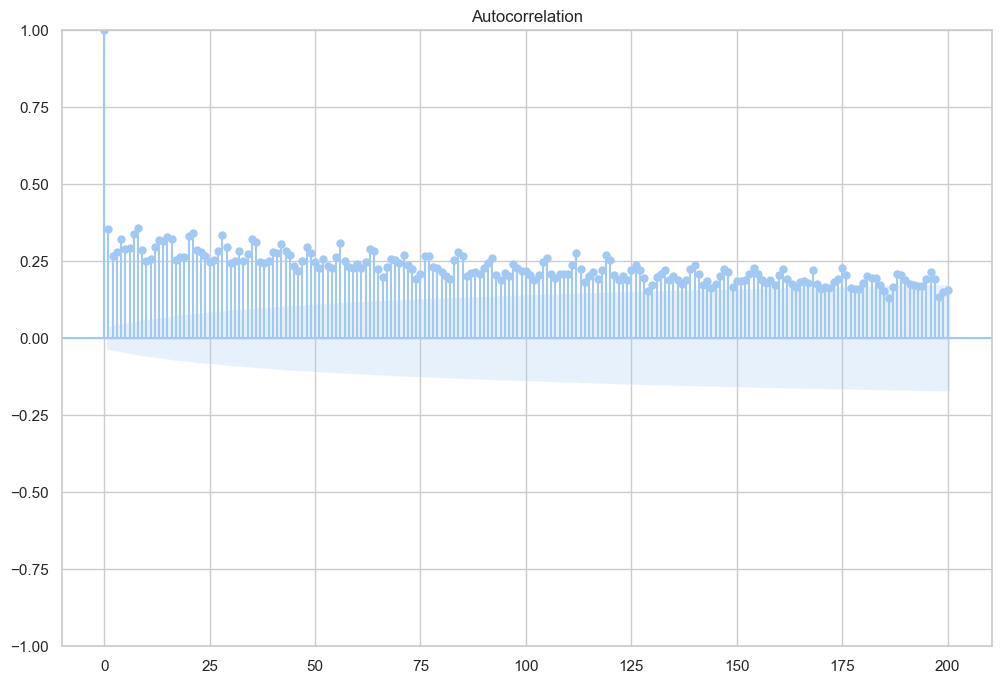

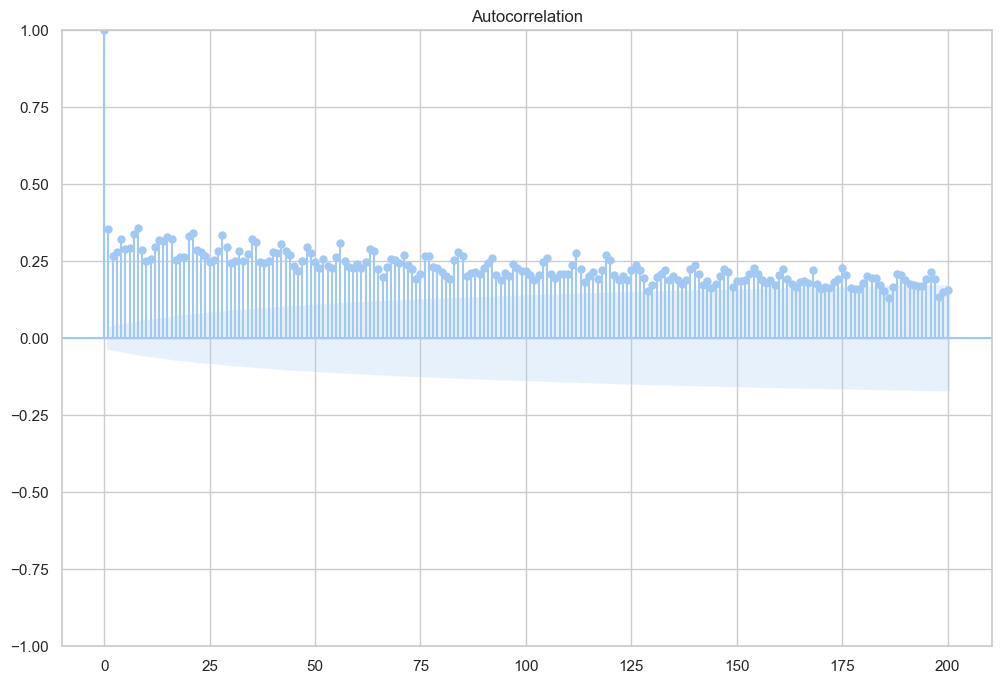

In [18]:
plot_acf(ts['severity'], lags=200)

As we can see, there are slight weekly autocorrelations.

## Mutual correlation